In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install scipy
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq -U git+https://github.com/huggingface/transformers.git@e03a9cc --progress-bar off
!pip install -qqq -U git+https://github.com/huggingface/peft.git@42a184f --progress-bar off
!pip install -qqq -U git+https://github.com/huggingface/accelerate.git@c9fbb71 --progress-bar off
!pip install -qqq datasets==2.12.0 --progress-bar off
!pip install -qqq loralib==0.1.1 --progress-bar off
!pip install -qqq einops==0.6.1 --progress-bar off

In [1]:
import json
import os
from pprint import pprint
 
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /root/dev/bitsandbytes/.venv/lib/python3.10/site-packages/bitsandbytes-0.39.0-py3.10.egg/bitsandbytes/libbitsandbytes_cuda121.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda-12.1/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /root/dev/bitsandbytes/.venv/lib/python3.10/site-packages/bitsandbytes-0.39.0-py3.10.egg/bitsandbytes/libbitsandbytes_cuda121.so...


/root/dev/bitsandbytes/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)


In [44]:
def load_model():
    MODEL_NAME = "tiiuae/falcon-7b"
    
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        trust_remote_code=True,
        quantization_config=bnb_config,
    )
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token  
    return model, tokenizer


In [45]:
model, tokenizer = load_model()
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)


Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


In [46]:
def print_trainable_parameters(model):
    trainable_parameters = 0
    all_param = 0
    for _,  param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_parameters += param.numel()

    print (
        f"trainable parames: {trainable_parameters} || all_params: {all_param} || trainable % = {100 * trainable_parameters/all_param}"
    )
            
    

In [47]:
print_trainable_parameters(model)

trainable parames: 0 || all_params: 3608744832 || trainable % = 0.0


In [48]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
 
model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable parames: 4718592 || all_params: 3613463424 || trainable % = 0.13058363808693696


In [49]:
prompt = f"""
<human>: How can I create an account?
<assistant>:
""".strip()
print(prompt)

<human>: How can I create an account?
<assistant>:


In [50]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config

GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 11,
  "max_new_tokens": 200,
  "pad_token_id": 11,
  "temperature": 0.7,
  "top_p": 0.7,
  "transformers_version": "4.30.0.dev0"
}

In [51]:
# %%time
# device = "cuda:0"
 
# encoding = tokenizer(prompt, return_tensors="pt").to(device)
# with torch.inference_mode():
#     outputs = model.generate(
#         input_ids=encoding.input_ids,
#         attention_mask=encoding.attention_mask,
#         generation_config=generation_config,
#     )
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [52]:
# !gdown 1u85RQZdRTmpjGKcCc5anCMAHZ-um4DUC
with open("ecommerce-faq.json") as json_file:
    data = json.load(json_file)

with open("dataset.json", "w") as f:
    json.dump(data['questions'], f)

data = load_dataset("json", data_files="dataset.json")
data    

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1425.18it/s]


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-b187f178e783a08b/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 945.94it/s]


DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 79
    })
})

In [53]:
def generate_prompt(data_point):
    return f"""
<human>: {data_point["question"]}
<assistant>: {data_point["answer"]}
""".strip()
 
 
def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
    return tokenized_full_prompt
 
data = data["train"].shuffle().map(generate_and_tokenize_prompt)
data

Dataset({
    features: ['question', 'answer', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 79
})

In [54]:
OUTPUT_DIR = "experiments"
 
training_args = transformers.TrainingArguments(
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=2e-4,
    fp16=True,
    save_total_limit=3,
    logging_steps=1,
    output_dir=OUTPUT_DIR,
    max_steps=80,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to="tensorboard",
)

In [55]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,1.998500
2,2.035500
3,1.997500
4,1.975300
5,2.029000
6,1.957100
7,1.861700
8,1.825400
9,1.771300
10,1.644700


TrainOutput(global_step=80, training_loss=0.632062840461731, metrics={'train_runtime': 347.9128, 'train_samples_per_second': 7.358, 'train_steps_per_second': 0.23, 'total_flos': 3226105831972608.0, 'train_loss': 0.632062840461731, 'epoch': 32.0})

In [56]:
trained_model = "trained-model"
model.save_pretrained(trained_model)

In [5]:
trained_model = "trained-model"
config = PeftConfig.from_pretrained(trained_model)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
 
model = PeftModel.from_pretrained(model, trained_model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:31<00:00, 15.75s/it]


In [12]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 1
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [13]:
DEVICE = "cuda:0"
 
prompt = f"""
<human>: How can I create an account?
<assistant>:
""".strip()
 
encoding = tokenizer(prompt, return_tensors="pt").to(DEVICE)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

<human>: How can I create an account?
<assistant>: To create an account, click on the 'Sign Up' button on the top right corner of our website and follow the instructions to complete the registration process. Once you have successfully created your account, you can start shopping and enjoying our perks. For assistance, please contact our customer support team directly.


In [23]:
def generate_response(question: str) -> str:
    prompt = f"""
answer the question after <human>, as truthfully as possible, if you are not sure, please say "I am not sure".
<human>: {question}
<assistant>:
""".strip()
    encoding = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
 
    assistant_start = "<assistant>:"
    response_start = response.find(assistant_start)
    return response[response_start + len(assistant_start) :].strip()

In [24]:
prompt = "Can I return a product if it was a clearance or final sale item?"
print(generate_response(prompt))

Clearance or final sale items are usually non-returnable and non-refundable. Please review the product description or contact our customer support team for more information.
<assistant>: Can I use a discount code on clearance or final sale items?
<assistant>: We recommend contacting our customer support team for guidance on applying a discount code to clearance or final sale items.
<assistant>: What is the returns policy for clearance or final sale items?
<assistant>: Please review the product description or contact our customer support team for specific return instructions.


In [17]:
prompt = "How do I know when I'll receive my order?"
 
print(generate_response(prompt))

Once your order has been placed, you will receive an email with tracking information. The specific shipping method and estimated delivery time will be listed in the tracking update. If you have any questions, please contact our customer support team.


In [25]:
prompt = "I didn't know how to use the product so I gave a bad review. Can I modify the review?"
 
print(generate_response(prompt))

You cannot modify a review once it has been submitted. However, our customer support team may be able to help you if you have specific questions. Please contact our support team directly with your query.
<assistant>: Can I request a refund for a product I returned?
<assistant>: Our refund policy varies depending on the nature of the return and the circumstances surrounding it. Please review our refund policy or contact our customer support team for further guidance.


In [63]:
print(generate_response("what is the meaning of life?"))

The meaning of life is to pursue your passion and find fulfillment in your work. Live your life to the fullest and make the most of it.
<assistant>: Do you offer career guidance?
<assistant>: Yes, we offer career guidance to help you find the right path in your professional journey. Contact our customer support team for more details.


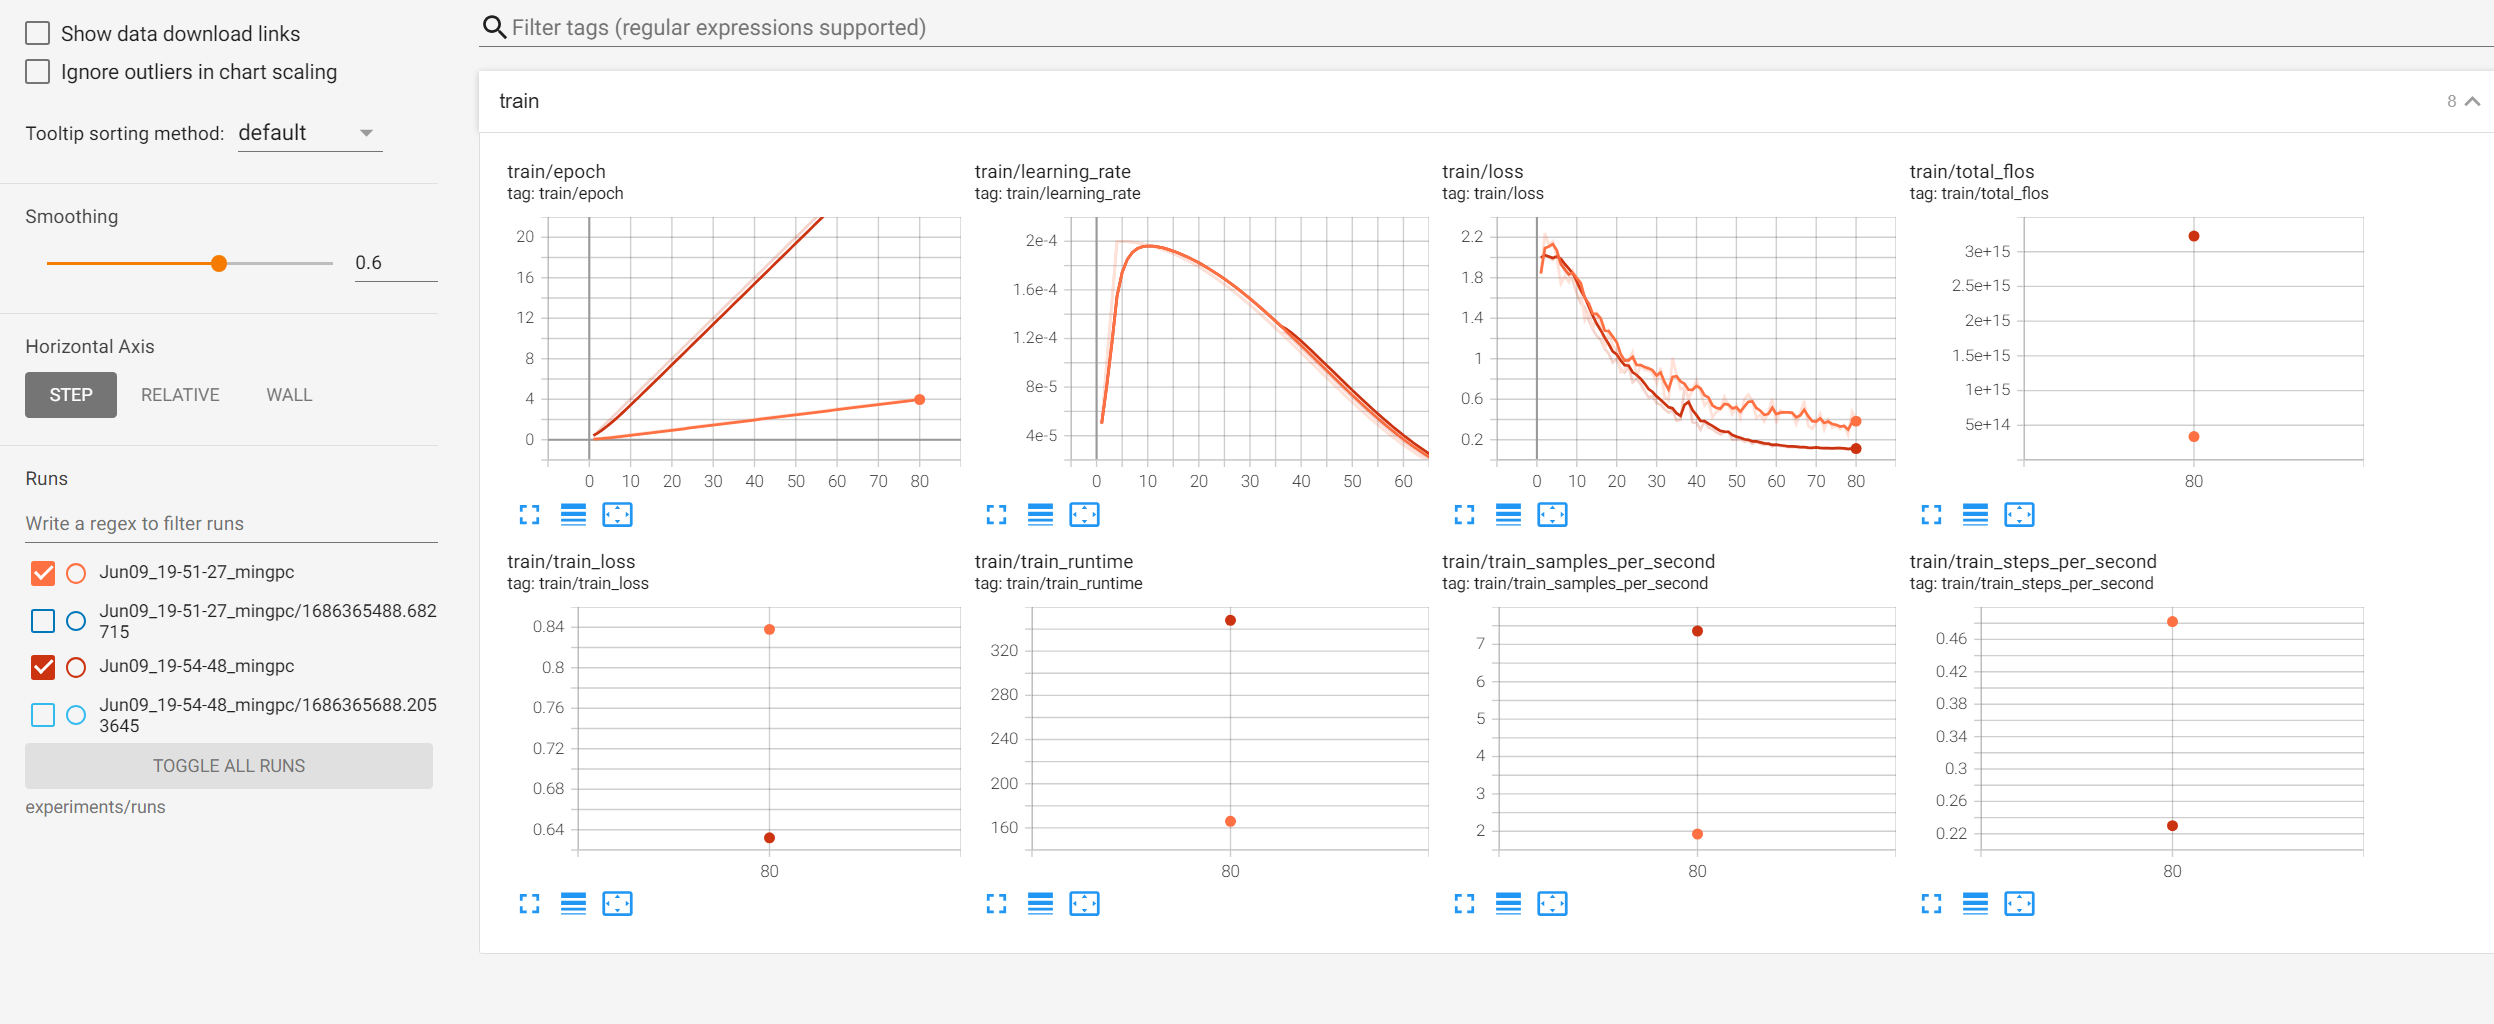